<a href="https://colab.research.google.com/github/AQLT/NLP/blob/main/Pr%C3%A9vision_cat%C3%A9gorie_m%C3%A9tier_ROME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guessing the domain of a job from its description

# 0 Downloading the database [optional]

All the data are gathered in a gist repository. You don't need to run the code of this section where we :

1. Download description from the Onisep database with webscrapping (https://data.laregion.fr/explore/dataset/onisep-metiers-onisep/table/)

2. Shape Pole Emploi databases (https://www.pole-emploi.org/opendata/repertoire-operationnel-des-meti.html?type=article)

Data : https://www.data.gouv.fr/fr/datasets/repertoire-operationnel-des-metiers-et-des-emplois-rome/#_

Link onisep : https://data.laregion.fr/explore/dataset/onisep-metiers-onisep/table/

Link ROME description : 
https://candidat.pole-emploi.fr/marche-du-travail/fichemetierrome?codeRome=E1301

[NOT USED] Link between ROME and other nomenclatures (PCS for example) : https://www.pole-emploi.org/opendata/repertoire-operationnel-des-meti.html?type=article



## 0.1 Onisep (webscraping)

In [ ]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup

First we download a file containing the links to webscrap : 1 link per job or more precisely be "appellation".

In [ ]:
!wget 'https://data.laregion.fr/explore/dataset/onisep-metiers-onisep/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B' -O onisep.csv

--2021-04-14 15:56:36--  https://data.laregion.fr/explore/dataset/onisep-metiers-onisep/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B
Resolving data.laregion.fr (data.laregion.fr)... 171.33.103.241, 109.232.232.161
Connecting to data.laregion.fr (data.laregion.fr)|171.33.103.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘onisep.csv’

onisep.csv              [     <=>            ] 460.52K   449KB/s    in 1.0s    

2021-04-14 15:56:40 (449 KB/s) - ‘onisep.csv’ saved [471572]



We shape this database.

In [ ]:
onisep_table = pd.read_csv("onisep.csv",sep=";")
onisep_table = onisep_table.dropna(subset=['code ROME', 'lien site onisep.fr'])
onisep_table = onisep_table[["libellé métier", "lien site onisep.fr", "GFE", "domaine/sous-domaine ONISEP","code ROME"]]
onisep_table = onisep_table.rename(columns={"libellé métier": "metier",
                                            "lien site onisep.fr": "url",
                                            "domaine/sous-domaine ONISEP": "domaine_ONISEP",
                                            "code ROME": "rome_code"})
onisep_table["sous_domaine_ONISEP"] = onisep_table["domaine_ONISEP"].apply(lambda x: re.sub(".*/","",x))
onisep_table["domaine_ONISEP"] = onisep_table["domaine_ONISEP"].apply(lambda x: re.sub("/.*","",x))
onisep_table = onisep_table.drop_duplicates(subset=['url']) # some url are duplicated
onisep_table

,metier,url,GFE,domaine_ONISEP,rome_code,sous_domaine_ONISEP
0,architecte,http://www.onisep.fr/http/redirection/metier/i...,C : Bâtiment,construction - architecture - travaux publics,F1101,architecture
1,géomètre-topographe,http://www.onisep.fr/http/redirection/metier/i...,C : Bâtiment,construction - architecture - travaux publics,F1108,sciences de la Terre
2,technicien / technicienne de maintenance en gé...,http://www.onisep.fr/http/redirection/metier/i...,"H : Electricité, énergie, électronique",construction - architecture - travaux publics,I1308,énergies
3,menuisier / menuisière,http://www.onisep.fr/http/redirection/metier/i...,M : Travail du bois,construction - architecture - travaux publics,H2202,bois
4,acheteur / acheteuse,http://www.onisep.fr/http/redirection/metier/i...,"Q : Commerce, gestion, finances","commerce, marketing, vente",M1101,grande distribution et petits commerces
...,...,...,...,...,...,...
1131,pédologue,http://www.onisep.fr/http/redirection/metier/i...,"T : Environnement, nettoyage, sécurité",sciences,F1105,sciences de la Terre
1136,statisticien industriel / statisticienne indus...,http://www.onisep.fr/http/redirection/metier/i...,P : Gestion et traitement de l'information (in...,sciences,M1403,mathématiques
1138,ingénieur / ingénieure en caractérisation des ...,http://www.onisep.fr/http/redirection/metier/i...,"J : Transformation des matériaux, procédés (bi...","matières premières, fabrication, industries",H1206,matériaux
1140,metteur / metteuse en scène,http://www.onisep.fr/http/redirection/metier/i...,"V : Arts, spectacle, audiovisuel","arts, culture, artisanat",L1301,arts du spectacle


And we perform a webscraping to get the description of each job.

In [ ]:
#20 minutes to run
def dl_description(url):
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  results = soup.find(id="en-quoi-consiste-ce-metier")
  paragraph = results.find_all('p')
  return ("\n".join([text.get_text() for text in paragraph]))
onisep_table["description"] = onisep_table.url.apply(dl_description)

We tidy the database.

In [ ]:
onisep_table["description"] = onisep_table["description"].apply(lambda x: re.sub("\xa0", " ", x))
onisep_table = onisep_table.rename(columns={"onisep_description": "description"}).drop(columns=["url"])
onisep_table.to_csv("onisep_description.csv", index=False)
#we have the database in csv and we put it on gist
onisep_table

,metier,GFE,domaine_ONISEP,rome_code,sous_domaine_ONISEP,description
0,architecte,C : Bâtiment,construction - architecture - travaux publics,F1101,architecture,"Construction d'un immeuble, réaménagement d'un..."
1,géomètre-topographe,C : Bâtiment,construction - architecture - travaux publics,F1108,sciences de la Terre,"L'oeil rivé dans le viseur de son tachéomètre,..."
2,technicien / technicienne de maintenance en gé...,"H : Electricité, énergie, électronique",construction - architecture - travaux publics,I1308,énergies,"Professionnel de l'ambiance et du confort, le ..."
3,menuisier / menuisière,M : Travail du bois,construction - architecture - travaux publics,H2202,bois,"Travailler le bois, lui donner une seconde vie..."
4,acheteur / acheteuse,"Q : Commerce, gestion, finances","commerce, marketing, vente",M1101,grande distribution et petits commerces,Le rôle d'un acheteur est d'acheter des produi...
...,...,...,...,...,...,...
1131,pédologue,"T : Environnement, nettoyage, sécurité",sciences,F1105,sciences de la Terre,Le pédologue est un scientifique spécialiste d...
1136,statisticien industriel / statisticienne indus...,P : Gestion et traitement de l'information (in...,sciences,M1403,mathématiques,Prévoir la durée de vie d'un produit industrie...
1138,ingénieur / ingénieure en caractérisation des ...,"J : Transformation des matériaux, procédés (bi...","matières premières, fabrication, industries",H1206,matériaux,L'ingénieur en caractérisation des matériaux c...
1140,metteur / metteuse en scène,"V : Arts, spectacle, audiovisuel","arts, culture, artisanat",L1301,arts du spectacle,Quand les 3 coups résonnent dans la salle et q...


## 0.2 Pole Emploi

In [ ]:
import pandas as pd
import re

First we download the files from the Pole Emploi API.

In [ ]:
!wget https://api.emploi-store.fr/api/docs/romeopen/REF_ROME_CSV/1/RefRomeCsv.zip -O metadata.zip
!unzip metadata.zip
!rm metadata.zip

--2021-04-09 12:42:25--  https://api.emploi-store.fr/api/docs/romeopen/REF_ROME_CSV/1/RefRomeCsv.zip
Resolving api.emploi-store.fr (api.emploi-store.fr)... 185.215.64.15
Connecting to api.emploi-store.fr (api.emploi-store.fr)|185.215.64.15|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 1509706 (1.4M) [application/zip]
Saving to: ‘metadata.zip’

metadata.zip        100%[===================>]   1.44M   235KB/s    in 6.3s    

2021-04-09 12:42:33 (233 KB/s) - ‘metadata.zip’ saved [1509706/1509706]

Archive:  metadata.zip
  inflating: unix_coherence_item_v346_utf8.csv  
  inflating: unix_composition_bloc_v346_utf8.csv  
  inflating: unix_cr_gd_dp_appellations_v346_utf8.csv  
  inflating: unix_cr_gd_dp_v346_utf8.csv  
  inflating: unix_descriptif_rubrique_v346_utf8.csv  
  inflating: unix_domaine_professionnel_v346_utf8.csv  
  inflating: unix_grand_domaine_v346_utf8.csv  
  inflating: unix_item_arborescence_v346_utf8.csv  
  inflating: unix_item_v346_utf8.csv  
  i

In the ROME database, there are two tree views:

- The principal one (`code_type_referentiel = 6`) organised in 4 levels:
  * 14 major fields (*grands domaines*) => **Our future classes**
  * 110 professional fields (*domaines professionnels*)
  * 532 ROME forms (*fiches ROME*)
  * 11 112 job names (*appellations métier*)
- The thematic one (`code_type_referentiel = 7`) with 17 main fields associated to 509 ROME forms: not all ROME forms are included in this tree and some of them are in several main fields at the same time (in total, 295 different ROME forms are used). That's why we will mainly focus on major the principal tree.

In the Pole Emploi database we have exhaustive description of the ROME jobs (532 observations), whereas in the Onisep database we have non exhaustive description of 715 job appellations (with the associated ROME forms, 354 ROME forms are observed).

We now load and tidy the different databases.

In [ ]:
arbo = pd.read_csv("unix_item_arborescence_v346_utf8.csv")

In [ ]:
thematic_tree = arbo[(arbo["code_type_noeud"]==3)&(arbo["code_type_referentiel"]==7)]
thematic_tree = thematic_tree.rename(columns={"code_noeud": "rome_code",
                                              "code_pere": "thematic_code",
                                              "libelle_item_arbo": "rome_title"})
thematic_tree = thematic_tree.drop(columns = ['code_ogr', 'code_item_arbo_associe', 'code_type_noeud',
       'libelle_type_noeud', 'statut',"code_type_referentiel"])
print(thematic_tree)
th_tree_desc = arbo[(arbo["code_type_noeud"]==2)&(arbo["code_type_referentiel"]==7)]
th_tree_desc = th_tree_desc.drop(columns = ['code_ogr', 'code_item_arbo_associe', 'code_type_noeud',
       'libelle_type_noeud', 'code_pere',"statut","code_type_referentiel"])
th_tree_desc = th_tree_desc.rename(columns={"code_noeud": "thematic_code",
                                            "libelle_item_arbo": "thematic_title"})
print(th_tree_desc)
thematic_tree = pd.merge(th_tree_desc,thematic_tree)
thematic_tree

     thematic_code rome_code                                         rome_title
675            001     A1201                            Bûcheronnage et élagage
676            001     A1202                     Entretien des espaces naturels
677            001     A1203         Aménagement et entretien des espaces verts
678            014     A1203         Aménagement et entretien des espaces verts
679            003     A1204                   Protection du patrimoine naturel
...            ...       ...                                                ...
1179           017     N4104                      Courses et livraisons express
1180           013     N4104                      Courses et livraisons express
1181           014     N4105  Conduite et livraison par tournées sur courte ...
1182           017     N4105  Conduite et livraison par tournées sur courte ...
1183           013     N4402  Exploitation et manoeuvre des remontées mécani...

[509 rows x 3 columns]
    thematic_cod

,thematic_code,thematic_title,rome_code,rome_title
0,001,Métiers de l'environnement et du développement...,A1201,Bûcheronnage et élagage
1,001,Métiers de l'environnement et du développement...,A1202,Entretien des espaces naturels
2,001,Métiers de l'environnement et du développement...,A1203,Aménagement et entretien des espaces verts
3,001,Métiers de l'environnement et du développement...,A1204,Protection du patrimoine naturel
4,001,Métiers de l'environnement et du développement...,A1205,Sylviculture
...,...,...,...,...
504,017,Métiers accessibles sans diplôme et sans expér...,N4101,Conduite de transport de marchandises sur long...
505,017,Métiers accessibles sans diplôme et sans expér...,N4102,Conduite de transport de particuliers
506,017,Métiers accessibles sans diplôme et sans expér...,N4103,Conduite de transport en commun sur route
507,017,Métiers accessibles sans diplôme et sans expér...,N4104,Courses et livraisons express


In [ ]:
principal_tree = arbo[(arbo["code_type_noeud"]==3)&(arbo["code_type_referentiel"]==6)]
principal_tree = principal_tree.rename(columns={"code_noeud": "rome_code",
                                              "code_pere": "professional_code",
                                              "libelle_item_arbo": "rome_title"})
principal_tree = principal_tree.drop(columns = ['code_ogr', 'code_item_arbo_associe', 'code_type_noeud',
       'libelle_type_noeud', 'statut',"code_type_referentiel"])
print(principal_tree)
pr_tree_desc = arbo[(arbo["code_type_noeud"]==2)&(arbo["code_type_referentiel"]==6)&(arbo["code_pere"]!="Racine AP")]
pr_tree_desc = pr_tree_desc.drop(columns = ['code_ogr', 'code_item_arbo_associe', 'code_type_noeud',
       'libelle_type_noeud',"statut","code_type_referentiel"])
pr_tree_desc = pr_tree_desc.rename(columns={"code_noeud": "professional_code",
                                            "code_pere": "major_code",
                                            "libelle_item_arbo": "professional_title",})
print(pr_tree_desc)
maj_tree_desc = arbo[(arbo["code_type_noeud"]==2)&(arbo["code_type_referentiel"]==6)&(arbo["code_pere"]=="Racine AP")]
maj_tree_desc = maj_tree_desc.drop(columns = ['code_ogr', 'code_item_arbo_associe', 'code_type_noeud',
       'libelle_type_noeud',"statut","code_type_referentiel", "code_pere"])
maj_tree_desc = maj_tree_desc.rename(columns={"code_noeud": "major_code",
                                            "libelle_item_arbo": "major_title"})
print(principal_tree)
principal_tree = pd.merge(pd.merge(maj_tree_desc,pr_tree_desc),
                          principal_tree)
principal_tree

    professional_code  ...                                         rome_title
125               A11  ...          Conduite d'engins agricoles et forestiers
126               A12  ...                            Bûcheronnage et élagage
127               A12  ...                     Entretien des espaces naturels
128               A12  ...         Aménagement et entretien des espaces verts
129               A12  ...                   Protection du patrimoine naturel
..                ...  ...                                                ...
652               N43  ...                                 Conduite sur rails
653               N43  ...                  Contrôle des transports en commun
654               N44  ...                        Circulation du réseau ferré
655               N44  ...  Exploitation et manoeuvre des remontées mécani...
656               N44  ...                          Manoeuvre du réseau ferré

[532 rows x 3 columns]
    major_code  ...                     

,major_code,major_title,professional_code,professional_title,rome_code,rome_title
0,A,"Agriculture et Pêche, Espaces naturels et Espa...",A11,Engins agricoles et forestiers,A1101,Conduite d'engins agricoles et forestiers
1,A,"Agriculture et Pêche, Espaces naturels et Espa...",A12,Espaces naturels et espaces verts,A1201,Bûcheronnage et élagage
2,A,"Agriculture et Pêche, Espaces naturels et Espa...",A12,Espaces naturels et espaces verts,A1202,Entretien des espaces naturels
3,A,"Agriculture et Pêche, Espaces naturels et Espa...",A12,Espaces naturels et espaces verts,A1203,Aménagement et entretien des espaces verts
4,A,"Agriculture et Pêche, Espaces naturels et Espa...",A12,Espaces naturels et espaces verts,A1204,Protection du patrimoine naturel
...,...,...,...,...,...,...
527,N,Transport et Logistique,N43,Personnel navigant du transport terrestre,N4301,Conduite sur rails
528,N,Transport et Logistique,N43,Personnel navigant du transport terrestre,N4302,Contrôle des transports en commun
529,N,Transport et Logistique,N44,Personnel sédentaire du transport ferroviaire ...,N4401,Circulation du réseau ferré
530,N,Transport et Logistique,N44,Personnel sédentaire du transport ferroviaire ...,N4402,Exploitation et manoeuvre des remontées mécani...


In [ ]:
principal_tree.to_csv("principal_tree.csv", index=False)
thematic_tree.to_csv("thematic_tree.csv", index=False)

In the Pole Emploi database, there are many kinds of texts associated to a ROME form. In the `unix_texte_v346_utf8.csv` database, you have three categories:

1. `definition`: a description of the job => **used**
2. `acces_a_em`: the required experience/diploma 
3. `cond_exercice_activite`: condition for exercising activity (for example "The activity may involve handling loads").

For this project, we only used the `definition`.

In [ ]:
rome_text = pd.read_csv("unix_texte_v346_utf8.csv")
rome_def = rome_text[rome_text["libelle_type_texte"]=='definition']
rome_def= rome_def.rename(columns={"libelle_texte": "description",
                                   "code_rome": "rome_code"}).drop(columns = ["position_libelle_txt","code_type_texte","libelle_type_texte"])
rome_def

,rome_code,description
0,A1101,"Réalise des travaux mécanisés agricoles, sylvi..."
1,A1201,Réalise des opérations de coupe et d''entretie...
2,A1201,Peut débarder les grumes. Peut estimer la vale...
3,A1201,Peut diriger une équipe ou diriger une entrepr...
4,A1202,Aménage et entretient des écosystèmes (espaces...
...,...,...
1497,N4402,Peut informer les clients sur les caractéristi...
1498,N4402,Peut coordonner l''activité d''une équipe.
1499,N4403,Réalise des opérations de formation de trains ...
1500,N4403,Peut acheminer une rame dans un périmètre limité.


In [ ]:
# Concatenation of multiple phrases
rome_def = rome_def.groupby(['rome_code'])["description"].apply(lambda x: '\n'.join(x)).reset_index()
rome_def

,rome_code,description
0,A1101,"Réalise des travaux mécanisés agricoles, sylvi..."
1,A1201,Réalise des opérations de coupe et d''entretie...
2,A1202,Aménage et entretient des écosystèmes (espaces...
3,A1203,Aménage et entretient des espaces verts (parcs...
4,A1204,Effectue la surveillance de site (espaces natu...
...,...,...
527,N4301,"Conduit un véhicule sur rails (train, métro, ...."
528,N4302,Contrôle les droits d''accès des voyageurs aux...
529,N4401,Surveille et coordonne les mouvements des trai...
530,N4402,"Réalise des opérations de mise en fonction, de..."


In [ ]:
#we have the database in csv and we put it on gist
rome_def.to_csv("rome_description.csv",index=False)

# 1 Import of the data and the packages


### 1.1 Import and installation of packages

In [ ]:
!pip install "transformers==2.5.1"
#!pip install -U torchtext==0.8.0

     |████████████████████████████████| 501kB 7.7MB/s 
     |████████████████████████████████| 133kB 15.1MB/s 
     |████████████████████████████████| 870kB 15.9MB/s 
     |████████████████████████████████| 5.6MB 33.3MB/s 
     |████████████████████████████████| 1.2MB 53.0MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 7.4MB 56.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=07214fe840564437e01e2728b062c96e07e021b726f6af5ca975d2c3633ac834
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
ERROR: botocore 1.20.52 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import torch
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from transformers.tokenization_camembert import CamembertTokenizer
from transformers import CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd

from collections import Counter

import nltk
from tqdm import tqdm
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from gensim.models import KeyedVectors
import random


seed_val = 42

### 1.2 Import of pretrained word2vec

In this project, due to the few number of observations, we used pre-trained word embedding from a French corpus available at https://fauconnier.github.io. The model was trained in the [FrWac corpus](https://wacky.sslmit.unibo.it/doku.php?id=corpora) of  1.6 billion of words, with a skip-gram approach and an embedding size of 200.

In [ ]:
!wget  https://s3.us-east-2.amazonaws.com/embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin

--2021-04-15 12:10:52--  https://s3.us-east-2.amazonaws.com/embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.101.241
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.101.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126052447 (120M) [application/octet-stream]
Saving to: ‘frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin’

frWac_non_lem_no_po 100%[===================>] 120.21M  39.5MB/s    in 3.0s    

2021-04-15 12:10:55 (39.5 MB/s) - ‘frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin’ saved [126052447/126052447]



In [ ]:
w2vecembedding = KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin", binary=True, unicode_errors="ignore")

### 1.3 Downloading the data

In [ ]:
!wget https://gist.github.com/AQLT/329c4af5e9418e94debe0ed721ba71ea/archive/0db14b6a9c9be77cbef12e4b3804e5e279e42aee.zip -O data.zip
!unzip -d data/ -j  -o data.zip
!rm data.zip

--2021-04-15 12:10:57--  https://gist.github.com/AQLT/329c4af5e9418e94debe0ed721ba71ea/archive/0db14b6a9c9be77cbef12e4b3804e5e279e42aee.zip
Resolving gist.github.com (gist.github.com)... 192.30.255.113
Connecting to gist.github.com (gist.github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/329c4af5e9418e94debe0ed721ba71ea/zip/0db14b6a9c9be77cbef12e4b3804e5e279e42aee [following]
--2021-04-15 12:10:58--  https://codeload.github.com/gist/329c4af5e9418e94debe0ed721ba71ea/zip/0db14b6a9c9be77cbef12e4b3804e5e279e42aee
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data.zip’

data.zip                [ <=>                ] 329.92K  --.-KB/s    in 0.03s   

2021-04-15 12:10:58 (11.0 MB/s) - ‘data.zip’ sav

In [ ]:
principal_tree = pd.read_csv("data/principal_tree.csv")
thematic_tree = pd.read_csv("data/thematic_tree.csv")
onisep_description = pd.read_csv("data/onisep_description.csv")
rome_description = pd.read_csv("data/rome_description.csv")
rome_description["table"] = "rome"
onisep_description["table"] = "onisep"
onisep_description = onisep_description.drop(columns=["metier","GFE","domaine_ONISEP","sous_domaine_ONISEP"])
print("Number of ROME descriptions (Pôle Emploi) : ",len(rome_description))
print("Number of JOB APPELLATION descriptions (Onisep) : ", len(onisep_description))
data = pd.concat([rome_description, onisep_description])
print("Total number of job descriptions : ", len(data))
data

Number of ROME descriptions (Pôle Emploi) :  532
Number of JOB APPELLATION descriptions (Onisep) :  715
Total number of job descriptions :  1247


,rome_code,description,table
0,A1101,"Réalise des travaux mécanisés agricoles, sylvi...",rome
1,A1201,Réalise des opérations de coupe et d''entretie...,rome
2,A1202,Aménage et entretient des écosystèmes (espaces...,rome
3,A1203,Aménage et entretient des espaces verts (parcs...,rome
4,A1204,Effectue la surveillance de site (espaces natu...,rome
...,...,...,...
710,F1105,Le pédologue est un scientifique spécialiste d...,onisep
711,M1403,Prévoir la durée de vie d'un produit industrie...,onisep
712,H1206,L'ingénieur en caractérisation des matériaux c...,onisep
713,L1301,Quand les 3 coups résonnent dans la salle et q...,onisep


As described in the section 1, we will focus on the principal tree. We will try to predict the *major_code* (there are 14 major fields) with the description obtained in of 532 ROME forms provided by Pole Emploi and 715 job descriptions provided by Onisep.

In [ ]:
data = pd.merge(data, principal_tree)
data = data.drop(columns = ["professional_code", "code_type_referentiel","professional_title"])
data

,rome_code,description,table,major_code,major_title,rome_title
0,A1101,"Réalise des travaux mécanisés agricoles, sylvi...",rome,A,"Agriculture et Pêche, Espaces naturels et Espa...",Conduite d'engins agricoles et forestiers
1,A1101,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",onisep,A,"Agriculture et Pêche, Espaces naturels et Espa...",Conduite d'engins agricoles et forestiers
2,A1101,"Depuis la cabine de sa machine, le conducteur ...",onisep,A,"Agriculture et Pêche, Espaces naturels et Espa...",Conduite d'engins agricoles et forestiers
3,A1201,Réalise des opérations de coupe et d''entretie...,rome,A,"Agriculture et Pêche, Espaces naturels et Espa...",Bûcheronnage et élagage
4,A1201,"Avec ses cordes de rappel, son harnais, ses mo...",onisep,A,"Agriculture et Pêche, Espaces naturels et Espa...",Bûcheronnage et élagage
...,...,...,...,...,...,...
1242,N4401,Surveille et coordonne les mouvements des trai...,rome,N,Transport et Logistique,Circulation du réseau ferré
1243,N4401,Le technicien de la circulation ferroviaire SN...,onisep,N,Transport et Logistique,Circulation du réseau ferré
1244,N4402,"Réalise des opérations de mise en fonction, de...",rome,N,Transport et Logistique,Exploitation et manoeuvre des remontées mécani...
1245,N4402,"Sur les pistes de ski, une panne d'une télécab...",onisep,N,Transport et Logistique,Exploitation et manoeuvre des remontées mécani...


We can notice that the dataset is not perfectly balanced :

In [ ]:
data[['major_code', 'table',"rome_code"]].groupby(['major_code', 'table']).count()

rome_code
major_code table            
A          onisep         44
           rome           30
B          onisep         21
           rome           19
C          onisep         19
           rome           25
D          onisep         35
           rome           39
E          onisep         43
           rome           23
F          onisep         58
           rome           38
G          onisep         34
           rome           30
H          onisep        122
           rome           94
I          onisep         31
           rome           28
J          onisep         38
           rome           32
K          onisep        132
           rome           71
L          onisep         33
           rome           22
M          onisep         78
           rome           44
N          onisep         27
           rome           37

# 2 Baseline : SVM on sentence-embeddings

In [ ]:
# We keep only the relevant columns : we want to predict the major code (grand domaine)
# using the description
y_variable = "major_code"
data_baseline = data[["description", y_variable]].copy()
data_baseline

,description,major_code
0,"Réalise des travaux mécanisés agricoles, sylvi...",A
1,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",A
2,"Depuis la cabine de sa machine, le conducteur ...",A
3,Réalise des opérations de coupe et d''entretie...,A
4,"Avec ses cordes de rappel, son harnais, ses mo...",A
...,...,...
1242,Surveille et coordonne les mouvements des trai...,N
1243,Le technicien de la circulation ferroviaire SN...,N
1244,"Réalise des opérations de mise en fonction, de...",N
1245,"Sur les pistes de ski, une panne d'une télécab...",N


In [ ]:
# we change the grades to 0-numbering because it is the classical way to do to perform the models
tag_to_ix = {}
i=0
for code in data_baseline[y_variable].unique():
  tag_to_ix[code]=i
  i += 1
print(tag_to_ix)
data_baseline['label'] = data_baseline[y_variable].replace(tag_to_ix)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13}


In [ ]:
# we tokenize using tweetTokenizer because the descriptions are quite short
tokenizer = TweetTokenizer()
def tokenize (text):
  tokens = tokenizer.tokenize(text)
  tokens = list(map(lambda x: x.lower(), tokens))
  return tokens

In [ ]:
#count  the number of occurences of each word
counts = Counter()
for index, row in data_baseline.iterrows():
    counts.update(tokenize(row['description']))
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 12834
num_words after: 6924


We lost about 4 000 words! This is expected because our corpus is quite small, the chance of having repeated words is quite small.

In [ ]:
# Create 3 objects
## W : embedding_matrix (1 line = 1 token and columns = embedding dimensions)
## vocab : vocabulary
## vocab_to_idx : dictionnary containing the link between each token and its id
def get_emb_matrix(pretrained, word_counts):
    """ Creates embedding matrix from word vectors"""
    emb_size = pretrained.vector_size
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in pretrained.vocab:
            W[i] = pretrained[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [ ]:
pretrained_weights, vocab, vocab2index = get_emb_matrix(w2vecembedding, counts)

In [ ]:
# Encode the sentence (sentence embedding = mean of word-embeddings)
def encode_sentence(text,vocab2index,pretrained_weights, emb_size):
    tokenized = tokenize(text)
    encoded = np.zeros(emb_size)
    for w in tokenized:
      encoded+= pretrained_weights[vocab2index.get(w, vocab2index["UNK"])]
    encoded = encoded/len(tokenized)
    return encoded#.tolist()

In [ ]:
# we create a new variable with the sentence embedding
data_baseline['encoded'] = data_baseline['description'].apply(lambda x: encode_sentence(x,
                                                                                vocab2index,
                                                                                pretrained_weights,
                                                                                w2vecembedding.vector_size))
data_baseline.head()

,description,major_code,label,encoded
0,"Réalise des travaux mécanisés agricoles, sylvi...",A,0,"[0.01813385658001957, 0.018583252631987516, 0...."
1,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",A,0,"[-0.003351222180450956, -0.05522170118427417, ..."
2,"Depuis la cabine de sa machine, le conducteur ...",A,0,"[-0.011989669149642336, -0.08174714997146257, ..."
3,Réalise des opérations de coupe et d''entretie...,A,0,"[-0.026510097059904585, -0.0020131743778297796..."
4,"Avec ses cordes de rappel, son harnais, ses mo...",A,0,"[-0.004031169962567778, -0.05995864183821071, ..."


In [ ]:
# create train 70 %
# create test 30 %
X_tr, X_val, y_train, y_valid = train_test_split(data_baseline.index.values, 
                                                  data_baseline.label.values, 
                                                  test_size=0.3, 
                                                  random_state=seed_val, 
                                                  stratify=data_baseline.label.values)
data_baseline['data_type'] = 'not_set'
data_baseline.loc[X_tr, 'data_type'] = 'train'
data_baseline.loc[X_val, 'data_type'] = 'val'
X_train = list(data_baseline.loc[X_tr,'encoded'])
X_valid = list(data_baseline.loc[X_val,'encoded'])
y_valid_desc = list(data_baseline.loc[X_val,'description'])
# To see the split between train and validation among all the label
data_baseline.groupby(['major_code', 'data_type']).count()

description  label  encoded
major_code data_type                             
A          train               52     52       52
           val                 22     22       22
B          train               28     28       28
           val                 12     12       12
C          train               31     31       31
           val                 13     13       13
D          train               52     52       52
           val                 22     22       22
E          train               46     46       46
           val                 20     20       20
F          train               67     67       67
           val                 29     29       29
G          train               45     45       45
           val                 19     19       19
H          train              151    151      151
           val                 65     65       65
I          train               41     41       41
           val                 18     18       18
J          train               49     49       49
           val                 21     21       21
K          train              142    142      142
           val                 61     61       61
L          train               38     38       38
           val                 17     17       17
M          train               85     85       85
           val                 37     37       37
N          train               45     45       45
           val                 19     19       19

In [ ]:
# we reshape the data as a big array
X_train_cv = np.vstack(np.array(X_train))
print(X_train_cv.shape)
X_val_cv = np.vstack(np.array(X_valid))
X_val_cv.shape

(872, 200)


(375, 200)

We do a binarization of labels : instead of a number from 0 to 13 we will have a dummy variable of the number associated to a label.

In [ ]:
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_valid_lb = lb_trained.transform(y_valid)
print(y_train_lb.shape, y_valid_lb.shape)

(872, 14) (375, 14)


In [ ]:
# we define a SVM model
svc = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svc, n_jobs=-1 ).fit(X_train_cv, y_train_lb)

In [ ]:
# We get the prediction
y_pred_svm = clf_svm.predict(X_val_cv)
print(y_pred_svm.shape)
y_score_svm = clf_svm.decision_function(X_val_cv)

(375, 14)


In [ ]:
# List to go from the number associated to a label to the label
key_list = list(tag_to_ix.keys())
val_list = list(tag_to_ix.values())

In [ ]:
def show_eval(y_true, y_pred, lb_trained):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  y_pred_names = [key_list[val_list.index(i)] for i in y_pred_names]
  y_true_names = [key_list[val_list.index(i)] for i in y_true_names]
  print( classification_report(y_true_names, y_pred_names) )
  labels = list(tag_to_ix.keys())
  cm = confusion_matrix(y_true_names, y_pred_names , labels = key_list) 
  
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
  plt.show()

              precision    recall  f1-score   support

           A       0.10      1.00      0.18        22
           B       1.00      0.17      0.29        12
           C       1.00      0.08      0.14        13
           D       1.00      0.32      0.48        22
           E       1.00      0.15      0.26        20
           F       0.90      0.31      0.46        29
           G       1.00      0.32      0.48        19
           H       0.84      0.55      0.67        65
           I       0.80      0.22      0.35        18
           J       1.00      0.76      0.86        21
           K       0.97      0.49      0.65        61
           L       1.00      0.59      0.74        17
           M       1.00      0.30      0.46        37
           N       1.00      0.58      0.73        19

    accuracy                           0.45       375
   macro avg       0.90      0.42      0.48       375
weighted avg       0.90      0.45      0.53       375



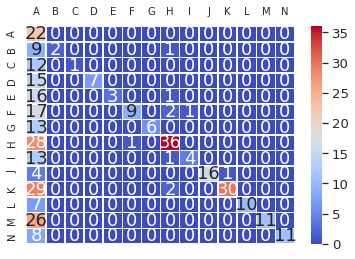

In [ ]:
show_eval(y_valid_lb, y_pred_svm, lb_trained)

# 3 LSTM

article : https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

code : https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification

pour bien comprendre les paramètes de nn.embedding : https://discuss.pytorch.org/t/how-should-i-understand-the-num-embeddings-and-embedding-dim-arguments-for-nn-embedding/60442/3

À réfléchir :

- changer le tokenizer ? Pas forcément, tester en enlevant les mots peu fréquents ou non

- choix des paramètres, notamment dimension, tester

- qualité de la prévision sur quelques phrases, également à faire sur Bert

- Remplacer output accuracy par F1 weighted


In [ ]:
# We keep only the relevant columns : we want to predict the major code (grand domaine)
# using the description
y_variable = "major_code"
data_lstm = data[["description", y_variable]].copy()
data_lstm

,description,major_code
0,"Réalise des travaux mécanisés agricoles, sylvi...",A
1,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",A
2,"Depuis la cabine de sa machine, le conducteur ...",A
3,Réalise des opérations de coupe et d''entretie...,A
4,"Avec ses cordes de rappel, son harnais, ses mo...",A
...,...,...
1242,Surveille et coordonne les mouvements des trai...,N
1243,Le technicien de la circulation ferroviaire SN...,N
1244,"Réalise des opérations de mise en fonction, de...",N
1245,"Sur les pistes de ski, une panne d'une télécab...",N


In [ ]:
# we change the grades to 0-numbering because it is the classical way to do to perform the models
tag_to_ix = {}
i=0
for code in data_lstm[y_variable].unique():
  tag_to_ix[code]=i
  i += 1
print(tag_to_ix)
data_lstm['label'] = data_lstm[y_variable].replace(tag_to_ix)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13}


In [ ]:
# we tokenize using tweetTokenizer because the descriptions are quite short
#tokenizer = TreebankWordTokenizer()
tokenizer = TweetTokenizer()

def tokenize (text):
  tokens = tokenizer.tokenize(text)
  tokens = list(map(lambda x: x.lower(), tokens))
  return tokens

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in data_lstm.iterrows():
    counts.update(tokenize(row['description']))
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 12834
num_words after: 6924


We lost about 4 000 words! This is expected because our corpus is quite small, the chance of having repeated words is quite small.
We then create a vocabulary to index mapping and encode our description text using this mapping. We choose the maximum length of any description to be 130 words (function `encode_sentence`) because the average length of description was around 107: putting this value too high dramatically increases the computational time and deteriorate the quality of the models.

In [ ]:
len_description = data_lstm.description.apply(lambda x: len(tokenize(x)))
print("mean:",np.mean(len_description))
np.quantile(len_description,q=[0,0.25,0.5,0.75,1])

mean: 126.00481154771451


array([ 23.,  69., 127., 177., 346.])

In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
# Encode the sentence (sentence embedding = mean of word-embeddings)
def encode_sentence(text, vocab2index, N=130):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
# we create an encoding for each sentence that contains the index of the first N words of the sentence
data_lstm['encoded'] = data_lstm['description'].apply(lambda x: np.array(encode_sentence(x,vocab2index ),dtype=object))
data_lstm.head()

,description,major_code,label,encoded
0,"Réalise des travaux mécanisés agricoles, sylvi...",A,0,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3, 13, 7..."
1,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",A,0,"[[38, 7, 39, 7, 1, 7, 1, 1, 7, 40, 41, 42, 43,..."
2,"Depuis la cabine de sa machine, le conducteur ...",A,0,"[[105, 27, 106, 23, 107, 108, 7, 42, 43, 109, ..."
3,Réalise des opérations de coupe et d''entretie...,A,0,"[[2, 3, 172, 23, 110, 34, 173, 17, 11, 16, 7, ..."
4,"Avec ses cordes de rappel, son harnais, ses mo...",A,0,"[[142, 158, 193, 23, 1, 7, 134, 194, 7, 158, 1..."


In [ ]:
# create train 70 %
# create test 30 %
X_tr, X_val, y_train, y_valid = train_test_split(data_lstm.index.values, 
                                                  data_lstm.label.values, 
                                                  test_size=0.3, 
                                                  random_state=seed_val, 
                                                  stratify=data_lstm.label.values)

data_lstm['data_type'] = 'not_set'
data_lstm.loc[X_tr, 'data_type'] = 'train'
data_lstm.loc[X_val, 'data_type'] = 'val'
y_train_desc = list(data_lstm.loc[X_tr,'description'])
y_valid_desc = list(data_lstm.loc[X_val,'description'])
X_train = list(data_lstm.loc[X_tr,'encoded'])
X_valid = list(data_lstm.loc[X_val,'encoded'])
data_lstm.groupby(['major_code', 'label', 'data_type']).count()

description  encoded
major_code label data_type                      
A          0     train               52       52
                 val                 22       22
B          1     train               28       28
                 val                 12       12
C          2     train               31       31
                 val                 13       13
D          3     train               52       52
                 val                 22       22
E          4     train               46       46
                 val                 20       20
F          5     train               67       67
                 val                 29       29
G          6     train               45       45
                 val                 19       19
H          7     train              151      151
                 val                 65       65
I          8     train               41       41
                 val                 18       18
J          9     train               49       49
                 val                 21       21
K          10    train              142      142
                 val                 61       61
L          11    train               38       38
                 val                 17       17
M          12    train               85       85
                 val                 37       37
N          13    train               45       45
                 val                 19       19

In [ ]:
# we create a class for a dataset
# the __getitem__ returns :
## - the word indices of the sentence
## - the label of the sentence
## - the number of words in the sentence
class DescriptionDataset(Dataset):
    def __init__(self, X, Y,Y_desc):
        self.X = X
        self.y = Y
        self.desc = Y_desc
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1],self.desc[idx]

In [ ]:
train_ds = DescriptionDataset(X_train, y_train,y_train_desc)
valid_ds = DescriptionDataset(X_valid, y_valid,y_valid_desc)

In [ ]:
batch_size = 5000 # Essayer de comprendre ce paramètre, quand on réduit ça augmente le temps de calcul
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
!nvidia-smi

Thu Apr 15 12:11:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [ ]:
# General function to train the models
def train_model(model, epochs=10, lr=0.001):
  model.to(device)
  
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.manual_seed(seed_val)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = torch.optim.Adam(parameters, lr=lr)
  loss_function = F.cross_entropy
  for i in range(epochs):
      model.train()
      sum_loss = 0.0
      total = 0
      for x, y, l,d in train_dl:
          x = x.long().to(device)
          y = y.long().to(device)
          y_pred = model(x, l)
          optimizer.zero_grad()
          loss = loss_function(y_pred, y)
          loss.backward()
          optimizer.step()
          sum_loss += loss.item()*y.shape[0]
          total += y.shape[0]
      val_loss, val_acc = validation_metrics(model, val_dl)
      if i % 20 == 1:
          print("train loss %.3f, val loss %.3f, val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))

def validation_metrics (model, valid_dl):
  model.eval()
  correct = 0
  total = 0
  sum_loss = 0.0
  for x, y, l,d in valid_dl:
      x = x.long().to(device)
      y = y.long().to(device)
      y_hat = model(x, l)
      loss = F.cross_entropy(y_hat, y)
      pred = torch.max(y_hat, 1)[1]
      correct += (pred == y).float().sum()
      total += y.shape[0]
      sum_loss += loss.item()*y.shape[0]
  return sum_loss/total, correct/total

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
  def __init__(self, vocab_size, embedding_dim, hidden_dim) :
      super().__init__()
      self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
      self.linear = nn.Linear(hidden_dim, len(tag_to_ix))
      self.dropout = nn.Dropout(0.2)
      
  def forward(self, x, l):
      x = self.embeddings(x)
      x = self.dropout(x)
      lstm_out, (ht, ct) = self.lstm(x)
      return self.linear(ht[-1])

In [ ]:
# this model accepts variable-length inputs (number of words in the sentence)
class LSTM_variable_input(torch.nn.Module) :
  def __init__(self, vocab_size, embedding_dim, hidden_dim) :
      super().__init__()
      self.hidden_dim = hidden_dim
      self.dropout = nn.Dropout(0.3)
      self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
      self.linear = nn.Linear(hidden_dim, len(tag_to_ix))
      
  def forward(self, x, s):
      x = self.embeddings(x)
      x = self.dropout(x)
      x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
      out_pack, (ht, ct) = self.lstm(x_pack)
      return self.linear(ht[-1])

In [ ]:
# Create 3 objects
## W : embedding_matrix (1 line = 1 token and columns = embedding dimensions)
## vocab : vocabulary
## vocab_to_idx : dictionnary containing the link between each token and its id
def get_emb_matrix(pretrained, word_counts):
    """ Creates embedding matrix from word vectors"""
    emb_size = pretrained.vector_size
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in pretrained.vocab:
            W[i] = pretrained[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [ ]:
pretrained_weights, vocab, vocab2index = get_emb_matrix(w2vecembedding, counts)

In [ ]:
# Same two model as before but using the word2vec embedding
class LSTM_w2vec_fixed_size(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, vec_weights, freeze_emd=True) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(vec_weights))
        if freeze_emd:
          self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(tag_to_ix))
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
class LSTM_w2vec2_variable_size(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, vec_weights, freeze_emd=True) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(vec_weights))
        if freeze_emd:
          self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(tag_to_ix))
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        return self.linear(ht[-1])

In [ ]:
model_fixed =  LSTM_fixed_len(vocab_size, embedding_dim = 50,
                              hidden_dim = 50)
model_fixed2 =  LSTM_fixed_len(vocab_size, embedding_dim = 75,
                              hidden_dim = 50)
model_fixed3 =  LSTM_fixed_len(vocab_size, embedding_dim = 100,
                              hidden_dim = 50)
model_fixed4 =  LSTM_fixed_len(vocab_size, embedding_dim = 125,
                              hidden_dim = 50)
model_fixed5 =  LSTM_fixed_len(vocab_size, embedding_dim = 150,
                              hidden_dim = 50)
model_fixed6 =  LSTM_fixed_len(vocab_size, embedding_dim = 175,
                              hidden_dim = 50)
model_fixed7 =  LSTM_fixed_len(vocab_size, embedding_dim = 200,
                              hidden_dim = 50)
train_model(model_fixed, epochs=400, lr=0.01)
train_model(model_fixed2, epochs=400, lr=0.01)
train_model(model_fixed3, epochs=400, lr=0.01)
train_model(model_fixed4, epochs=400, lr=0.01)
train_model(model_fixed5, epochs=400, lr=0.01)
train_model(model_fixed6, epochs=400, lr=0.01)
train_model(model_fixed7, epochs=400, lr=0.01)

train loss 2.607, val loss 2.596, val accuracy 0.165
train loss 1.987, val loss 2.632, val accuracy 0.147
train loss 1.277, val loss 3.139, val accuracy 0.168
train loss 1.114, val loss 3.509, val accuracy 0.133
train loss 1.072, val loss 3.606, val accuracy 0.141
train loss 1.008, val loss 3.715, val accuracy 0.173
train loss 0.882, val loss 3.801, val accuracy 0.187
train loss 0.817, val loss 4.097, val accuracy 0.160
train loss 0.881, val loss 4.072, val accuracy 0.165
train loss 0.765, val loss 4.152, val accuracy 0.160
train loss 0.663, val loss 4.304, val accuracy 0.181
train loss 0.709, val loss 4.284, val accuracy 0.189
train loss 0.605, val loss 4.457, val accuracy 0.165
train loss 0.554, val loss 4.581, val accuracy 0.189
train loss 0.448, val loss 4.760, val accuracy 0.200
train loss 0.415, val loss 4.825, val accuracy 0.187
train loss 0.376, val loss 5.032, val accuracy 0.181
train loss 0.340, val loss 5.041, val accuracy 0.195
train loss 0.370, val loss 5.029, val accuracy

In [ ]:
model_fixed =  LSTM_fixed_len(vocab_size, embedding_dim = 50,
                              hidden_dim = 50)
train_model(model_fixed, epochs=400, lr=0.01)

train loss 2.608, val loss 2.601, val accuracy 0.171
train loss 1.909, val loss 2.658, val accuracy 0.163
train loss 1.271, val loss 3.163, val accuracy 0.163
train loss 1.088, val loss 3.418, val accuracy 0.144
train loss 1.012, val loss 3.594, val accuracy 0.163
train loss 1.060, val loss 3.636, val accuracy 0.147
train loss 1.005, val loss 3.808, val accuracy 0.173
train loss 0.899, val loss 3.841, val accuracy 0.165
train loss 1.003, val loss 3.786, val accuracy 0.157
train loss 0.859, val loss 3.816, val accuracy 0.171
train loss 0.863, val loss 4.087, val accuracy 0.179
train loss 0.732, val loss 4.106, val accuracy 0.195
train loss 0.641, val loss 4.440, val accuracy 0.181
train loss 0.645, val loss 4.768, val accuracy 0.189
train loss 0.558, val loss 4.615, val accuracy 0.179
train loss 0.540, val loss 4.599, val accuracy 0.160
train loss 0.418, val loss 5.014, val accuracy 0.181
train loss 0.356, val loss 5.204, val accuracy 0.168
train loss 0.313, val loss 5.468, val accuracy

In [ ]:
model_variable = LSTM_variable_input(vocab_size, embedding_dim = 50,
                              hidden_dim = 50)
train_model(model_variable, epochs=200, lr=0.01) #Faster convergence

train loss 2.578, val loss 2.551, val accuracy 0.173
train loss 1.752, val loss 2.497, val accuracy 0.243
train loss 0.809, val loss 3.088, val accuracy 0.277
train loss 0.308, val loss 3.366, val accuracy 0.307
train loss 0.102, val loss 3.753, val accuracy 0.312
train loss 0.048, val loss 4.108, val accuracy 0.336
train loss 0.045, val loss 4.098, val accuracy 0.312
train loss 0.035, val loss 4.173, val accuracy 0.331
train loss 0.015, val loss 4.129, val accuracy 0.355
train loss 0.011, val loss 4.311, val accuracy 0.355


In [ ]:
w2vec_fixeds_freeze = LSTM_w2vec_fixed_size(vocab_size,
                         embedding_dim = w2vecembedding.vector_size,
                         hidden_dim = 50,
                         vec_weights = pretrained_weights,
                         freeze_emd = True)
train_model(w2vec_fixeds_freeze, epochs=200, lr=0.01)

train loss 2.593, val loss 2.553, val accuracy 0.163
train loss 2.355, val loss 2.427, val accuracy 0.197
train loss 2.117, val loss 2.416, val accuracy 0.219
train loss 2.266, val loss 2.668, val accuracy 0.211
train loss 1.687, val loss 2.338, val accuracy 0.272
train loss 1.610, val loss 2.342, val accuracy 0.277
train loss 1.382, val loss 2.242, val accuracy 0.317
train loss 1.184, val loss 2.321, val accuracy 0.307
train loss 1.122, val loss 2.382, val accuracy 0.296
train loss 1.030, val loss 2.356, val accuracy 0.347


In [ ]:
w2vec_fixeds_notfreeze = LSTM_w2vec_fixed_size(vocab_size,
                         embedding_dim = w2vecembedding.vector_size,
                         hidden_dim = 50,
                         vec_weights = pretrained_weights,
                         freeze_emd = False)
train_model(w2vec_fixeds_notfreeze, epochs=300, lr=0.01)

train loss 2.603, val loss 2.573, val accuracy 0.149
train loss 1.340, val loss 2.698, val accuracy 0.184
train loss 1.131, val loss 3.020, val accuracy 0.176
train loss 1.104, val loss 3.152, val accuracy 0.165
train loss 1.061, val loss 3.434, val accuracy 0.152
train loss 1.164, val loss 3.453, val accuracy 0.155
train loss 1.026, val loss 3.056, val accuracy 0.181
train loss 0.839, val loss 3.368, val accuracy 0.200
train loss 0.700, val loss 3.487, val accuracy 0.187
train loss 0.527, val loss 3.561, val accuracy 0.253
train loss 0.367, val loss 3.934, val accuracy 0.245
train loss 0.346, val loss 3.905, val accuracy 0.251
train loss 0.280, val loss 4.245, val accuracy 0.248
train loss 0.124, val loss 4.664, val accuracy 0.240
train loss 0.229, val loss 4.727, val accuracy 0.272


In [ ]:
w2vec_variables_freeze = LSTM_w2vec2_variable_size(vocab_size,
                         embedding_dim = w2vecembedding.vector_size,
                         hidden_dim = 50,
                         vec_weights = pretrained_weights,
                         freeze_emd = True)
train_model(w2vec_variables_freeze, epochs=200, lr=0.01)

train loss 2.582, val loss 2.536, val accuracy 0.163
train loss 2.111, val loss 2.215, val accuracy 0.227
train loss 1.661, val loss 1.774, val accuracy 0.419
train loss 1.339, val loss 1.596, val accuracy 0.491
train loss 1.173, val loss 1.505, val accuracy 0.507
train loss 0.816, val loss 1.324, val accuracy 0.595
train loss 0.757, val loss 1.425, val accuracy 0.549
train loss 0.437, val loss 1.360, val accuracy 0.573
train loss 0.244, val loss 1.389, val accuracy 0.605
train loss 0.145, val loss 1.511, val accuracy 0.627


In [ ]:
w2vec_variables_notfreeze = LSTM_w2vec2_variable_size(vocab_size,
                         embedding_dim = w2vecembedding.vector_size,
                         hidden_dim = 50,
                         vec_weights = pretrained_weights,
                         freeze_emd = False)
train_model(w2vec_variables_notfreeze, epochs=100, lr=0.01)

train loss 2.589, val loss 2.547, val accuracy 0.165
train loss 0.457, val loss 2.522, val accuracy 0.312
train loss 0.014, val loss 3.538, val accuracy 0.307
train loss 0.002, val loss 3.922, val accuracy 0.320
train loss 0.001, val loss 4.139, val accuracy 0.336


In [ ]:
key_list = list(tag_to_ix.keys())
val_list = list(tag_to_ix.values())

In [ ]:
def matrix_pred (model, valid_dl):
  model.eval()
  data={"description":[],"label":[],"y_pred":[]}
  y_hat = np.array([], dtype=np.int32).reshape(0,len(tag_to_ix))
  for x, y, l, d in valid_dl:
    x = x.long().to(device)
    y = y.long().to(device)
    y_hat_tmp = model(x, l).cpu()
    y_hat = np.concatenate(( y_hat, y_hat_tmp.detach().numpy()))
    pred = torch.max(y_hat_tmp, 1)[1]

    data["label"] += [key_list[val_list.index(i)] for i in y]
    data['y_pred'] += [key_list[val_list.index(i)] for i in pred]
    data['description'] += d
  return pd.DataFrame(data)

In [ ]:
def f1_w_score(model,valid_dl):
  data = matrix_pred(model,valid_dl)
  y_true = data.label
  y_pred = data.y_pred
  return f1_score(y_true, y_pred, average='weighted')

In [ ]:
def diagnostics(model, valid_dl):
  data = matrix_pred(model,valid_dl)
  y_true = data.label
  y_pred = data.y_pred
  print(classification_report(y_true, y_pred) )
  cm = confusion_matrix(y_true, y_pred , labels = key_list) 
  df_cm = pd.DataFrame(cm, index=key_list, columns=key_list)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
  plt.show()

In [ ]:
import os, sys
# To hind the print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def test_parameter_lstm(model_class, embedding_dim, hidden_dim, lr = 0.01, epochs = 400):
  model = model_class(vocab_size, embedding_dim = embedding_dim,
                      hidden_dim = hidden_dim)
  with HiddenPrints():
    train_model(model, epochs=epochs, lr=lr)
  return f1_w_score(model, val_dl)

0.13523472432275502

In [ ]:
test_parameter_lstm(LSTM_fixed_len, embedding_dim = 50,hidden_dim = 50, epochs=10)

0.08593608516089135

In [ ]:
[f1_w_score(m, val_dl) for m in [model_fixed,model_fixed2,model_fixed3,model_fixed4,
 model_fixed5, model_fixed6, model_fixed7]]

[0.15101212465346206,
 0.23228205745239733,
 0.1763450733840915,
 0.19019854620865753,
 0.18040302852602852,
 0.225223695127562,
 0.1830305711394988]

In [ ]:
matrix_pred(model_fixed, val_dl)

,description,label,y_pred
0,"Diagnostique les pathologies dentaires, réalis...",J,A
1,Comme les échanges internationaux se multiplie...,E,H
2,Employé dans un cabinet de recrutement ou une ...,M,E
3,"Réalise les opérations d''abattage d''animaux,...",H,M
4,Aide et accompagne les personnes handicapées o...,K,F
...,...,...,...
370,Conduit et manipule différents types d''engins...,F,C
371,"Derrière la caméra ou caméra à l'épaule, le ca...",L,L
372,"Directement rattaché à la direction générale, ...",M,H
373,Organise et supervise le fonctionnement (admin...,K,K


              precision    recall  f1-score   support

           A       0.07      0.09      0.08        22
           B       0.00      0.00      0.00        12
           C       0.00      0.00      0.00        13
           D       0.06      0.09      0.07        22
           E       0.15      0.10      0.12        20
           F       0.17      0.10      0.13        29
           G       0.06      0.05      0.06        19
           H       0.40      0.32      0.36        65
           I       0.08      0.11      0.09        18
           J       0.00      0.00      0.00        21
           K       0.23      0.20      0.21        61
           L       0.12      0.12      0.12        17
           M       0.24      0.32      0.28        37
           N       0.23      0.32      0.27        19

    accuracy                           0.17       375
   macro avg       0.13      0.13      0.13       375
weighted avg       0.18      0.17      0.17       375



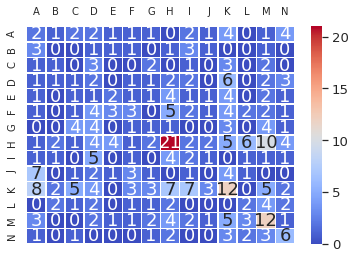

In [ ]:
diagnostics(model_fixed, val_dl)

              precision    recall  f1-score   support

           A       0.38      0.27      0.32        22
           B       0.57      0.33      0.42        12
           C       0.44      0.31      0.36        13
           D       0.46      0.55      0.50        22
           E       0.25      0.10      0.14        20
           F       0.23      0.21      0.22        29
           G       0.47      0.37      0.41        19
           H       0.46      0.55      0.50        65
           I       0.43      0.17      0.24        18
           J       0.38      0.24      0.29        21
           K       0.42      0.56      0.48        61
           L       0.36      0.24      0.29        17
           M       0.25      0.41      0.31        37
           N       0.47      0.47      0.47        19

    accuracy                           0.39       375
   macro avg       0.40      0.34      0.35       375
weighted avg       0.39      0.39      0.38       375



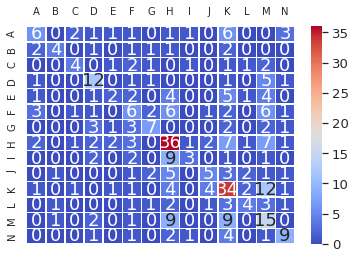

In [ ]:
diagnostics(model_variable, val_dl)

***word2vec + LSTM, fixed size of the sentence, freezed embedding***
              precision    recall  f1-score   support

           A       0.20      0.23      0.21        22
           B       0.11      0.08      0.10        12
           C       0.00      0.00      0.00        13
           D       0.15      0.27      0.20        22
           E       0.25      0.15      0.19        20
           F       0.23      0.17      0.20        29
           G       0.23      0.26      0.24        19
           H       0.50      0.46      0.48        65
           I       0.24      0.50      0.33        18
           J       0.08      0.10      0.09        21
           K       0.39      0.26      0.31        61
           L       0.25      0.12      0.16        17
           M       0.20      0.24      0.22        37
           N       0.38      0.26      0.31        19

    accuracy                           0.26       375
   macro avg       0.23      0.22      0.22       375
weighted av

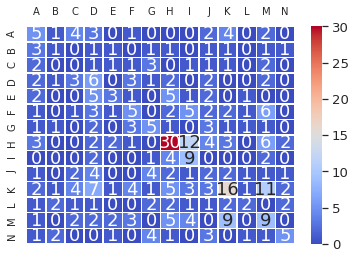

----------------------------------------------------------------------------
***word2vec + LSTM, fixed size of the sentence, not freezed embedding***
              precision    recall  f1-score   support

           A       0.11      0.05      0.06        22
           B       0.20      0.08      0.12        12
           C       0.00      0.00      0.00        13
           D       0.00      0.00      0.00        22
           E       0.32      0.30      0.31        20
           F       0.50      0.28      0.36        29
           G       0.50      0.16      0.24        19
           H       0.36      0.78      0.49        65
           I       0.29      0.11      0.16        18
           J       0.40      0.19      0.26        21
           K       0.43      0.43      0.43        61
           L       0.75      0.35      0.48        17
           M       0.20      0.43      0.28        37
           N       0.17      0.05      0.08        19

    accuracy                          

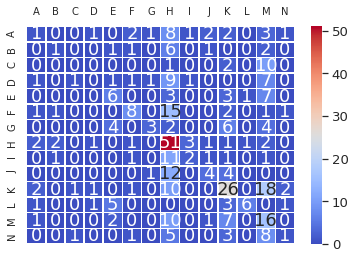

----------------------------------------------------------------------------
***word2vec + LSTM, variable size of the sentence, not freezed embedding***
              precision    recall  f1-score   support

           A       0.79      0.50      0.61        22
           B       0.67      0.67      0.67        12
           C       0.46      0.46      0.46        13
           D       0.63      0.55      0.59        22
           E       0.56      0.45      0.50        20
           F       0.57      0.59      0.58        29
           G       0.65      0.79      0.71        19
           H       0.70      0.74      0.72        65
           I       0.54      0.39      0.45        18
           J       0.71      0.71      0.71        21
           K       0.60      0.59      0.60        61
           L       0.79      0.88      0.83        17
           M       0.53      0.62      0.57        37
           N       0.70      0.84      0.76        19

    accuracy                       

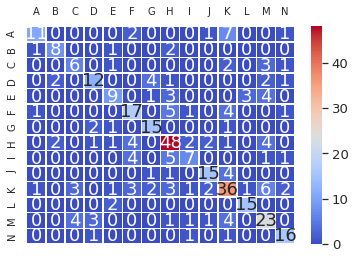

----------------------------------------------------------------------------
***word2vec + LSTM, variable size of the sentence, not freezed embedding***
              precision    recall  f1-score   support

           A       0.26      0.23      0.24        22
           B       0.26      0.42      0.32        12
           C       0.20      0.23      0.21        13
           D       0.26      0.45      0.33        22
           E       0.28      0.25      0.26        20
           F       0.71      0.17      0.28        29
           G       0.23      0.26      0.24        19
           H       0.41      0.37      0.39        65
           I       0.13      0.28      0.18        18
           J       0.34      0.48      0.40        21
           K       0.42      0.36      0.39        61
           L       0.46      0.35      0.40        17
           M       0.14      0.08      0.10        37
           N       0.30      0.37      0.33        19

    accuracy                       

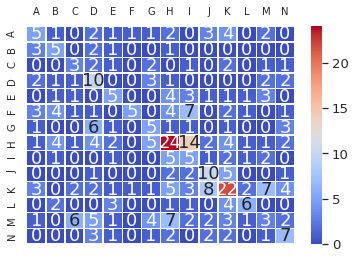

In [ ]:
print("***word2vec + LSTM, fixed size of the sentence, freezed embedding***")
diagnostics(w2vec_fixeds_notfreeze, val_dl)
print("----------------------------------------------------------------------------")
print("***word2vec + LSTM, fixed size of the sentence, not freezed embedding***")
diagnostics(w2vec_fixeds_freeze, val_dl)
print("----------------------------------------------------------------------------")
print("***word2vec + LSTM, variable size of the sentence, not freezed embedding***")
diagnostics(w2vec_variables_freeze, val_dl)
print("----------------------------------------------------------------------------")
print("***word2vec + LSTM, variable size of the sentence, not freezed embedding***")
diagnostics(w2vec_variables_notfreeze, val_dl)

# 4 CAMEMBERT 

In this section we perform a fine-tuning of the pretrained model of CAMEMBERT for sequence classification

https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

In [ ]:
!nvidia-smi

Thu Apr 15 12:30:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   1356MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# We keep only the relevant columns : we want to predict the major code (grand domaine)
# using the description
y_variable = "major_code"
data_bert= data[["description", y_variable]].copy()

# we change the grades to 0-numbering because it is the classical way to do to perform the models
tag_to_ix = {}
i=0
for code in data_bert[y_variable].unique():
  tag_to_ix[code]=i
  i += 1
print(tag_to_ix)
data_bert['label'] = data_bert[y_variable].replace(tag_to_ix)
data_bert

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13}


,description,major_code,label
0,"Réalise des travaux mécanisés agricoles, sylvi...",A,0
1,"Tracteur, moissonneuse-batteuse, ensileuse, ép...",A,0
2,"Depuis la cabine de sa machine, le conducteur ...",A,0
3,Réalise des opérations de coupe et d''entretie...,A,0
4,"Avec ses cordes de rappel, son harnais, ses mo...",A,0
...,...,...,...
1242,Surveille et coordonne les mouvements des trai...,N,13
1243,Le technicien de la circulation ferroviaire SN...,N,13
1244,"Réalise des opérations de mise en fonction, de...",N,13
1245,"Sur les pistes de ski, une panne d'une télécab...",N,13


In [ ]:
# create train 70 %
# create test 30 %
X_train, X_val, y_train, y_val = train_test_split(data_bert.index.values, 
                                                  data_bert.label.values, 
                                                  test_size=0.3, 
                                                  random_state=seed_val, 
                                                  stratify=data_bert.label.values)

data_bert['data_type'] = 'not_set'
data_bert.loc[X_train, 'data_type'] = 'train'
data_bert.loc[X_val, 'data_type'] = 'val'

data_bert.groupby(['major_code', 'label', 'data_type']).count()

description
major_code label data_type             
A          0     train               52
                 val                 22
B          1     train               28
                 val                 12
C          2     train               31
                 val                 13
D          3     train               52
                 val                 22
E          4     train               46
                 val                 20
F          5     train               67
                 val                 29
G          6     train               45
                 val                 19
H          7     train              151
                 val                 65
I          8     train               41
                 val                 18
J          9     train               49
                 val                 21
K          10    train              142
                 val                 61
L          11    train               38
                 val                 17
M          12    train               85
                 val                 37
N          13    train               45
                 val                 19

In the following code we format the data so that it is easily usable in the model. In particular we specify a maximum length for the sentence (= maximum number of tokens) to 256. Indeed, we notice that to increase its value dramatically increases the time computation without any significant gain in the quality of the model: the first tokens are enough to predict the label. This value is higher than the one used in the previous section because CAMEMBERT divides the sentence in much more tokens (especially due to the byte pair encoding for unknown words).



In [ ]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base", 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    data_bert[data_bert.data_type=='train'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data_bert[data_bert.data_type=='val'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data_bert[data_bert.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data_bert[data_bert.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
# To understand the previous max_length parameter two examples :
## - in the first one the number of tokens is lower than max_len (the number 1 is used to complete the sentence)
## - in the second one the number of tokens is higher than max_len (truncated sentence)
print(tokenizer.tokenize("Bonjour, j'espère que vous appréciez la lecture de ce projet !"))
print(tokenizer.batch_encode_plus(
    ["Bonjour, j'espère que vous appréciez la lecture de ce projet !"], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=20, 
    return_tensors='pt'
)['input_ids'])
print(tokenizer.batch_encode_plus(
    ["Bonjour, j'espère que vous appréciez la lecture de ce projet !"], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=10, 
    return_tensors='pt'
)['input_ids'])

['▁bonjour', ',', '▁j', "'", 'espère', '▁que', '▁vous', '▁appréciez', '▁la', '▁lecture', '▁de', '▁ce', '▁projet', '▁!']
tensor([[    5,  5061,     7,    76,    11,  1612,    27,    39, 25331,    13,
          1147,     8,    44,   327,    83,     6,     1,     1,     1,     1]])
tensor([[    5,  5061,     7,    76,    11,  1612,    27,    39, 25331,     6]])


In [ ]:
#load the pretrained camembert model
camembert = CamembertForSequenceClassification.from_pretrained("camembert-base",
                                                      num_labels=len(tag_to_ix),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camembert.to(device)
optimizer = AdamW(camembert.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [ ]:
# 5 epochs is enough to have good performance             
epochs = 5
batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
# check documentation, mentionned here: https://huggingface.co/transformers/training.html
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# To compute the f1-score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
# to compute an accuracy per class
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in tag_to_ix.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# The model by epoch is stored in a folder data_volum
!mkdir data_volume

In [ ]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#function to evaluate the model on the validation dataset
def evaluate(dataloader_val):

    camembert.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = camembert(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    camembert.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        camembert.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = camembert(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(camembert.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(camembert.state_dict(), f'data_volume/finetuned_CAMEMBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Epoch 1:   0%|          | 0/291 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

  0%|          | 0/5 [01:00<?, ?it/s]


Epoch 1
Training loss: 2.500431971042017


Epoch 2:   0%|          | 0/291 [00:00<?, ?it/s]

Validation loss: 2.299462992668152
F1 Score (Weighted): 0.265672083425259



 20%|██        | 1/5 [02:07<04:28, 67.02s/it]


Epoch 2
Training loss: 2.1378818787250324


Epoch 3:   0%|          | 0/291 [00:00<?, ?it/s]

Validation loss: 1.9206763706207275
F1 Score (Weighted): 0.670901228775829



 40%|████      | 2/5 [03:14<03:20, 66.92s/it]


Epoch 3
Training loss: 1.794859683390745


Epoch 4:   0%|          | 0/291 [00:00<?, ?it/s]

Validation loss: 1.6889254741668702
F1 Score (Weighted): 0.7318930379383516



 60%|██████    | 3/5 [04:21<02:13, 66.99s/it]


Epoch 4
Training loss: 1.563307114073501


Epoch 5:   0%|          | 0/291 [00:00<?, ?it/s]

Validation loss: 1.557703369140625
F1 Score (Weighted): 0.7612846033291883



 80%|████████  | 4/5 [05:28<01:06, 66.99s/it]


Epoch 5
Training loss: 1.4460687995776278


100%|██████████| 5/5 [05:34<00:00, 66.99s/it]

Validation loss: 1.5139466347694397
F1 Score (Weighted): 0.7688127458806386


In [ ]:
key_list = list(tag_to_ix.keys())
val_list = list(tag_to_ix.values())

# We retreive the predictions and the true values
val_loss, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

y_true = [key_list[val_list.index(i)] for i in true_vals]
y_pred = [key_list[val_list.index(i)] for i in preds_flat]

In [ ]:
tmp.groupby(["y_true"]).count()

,description,major_code,label,data_type
y_true,,,,
A,22,22,22,22
B,12,12,12,12
C,13,13,13,13
D,22,22,22,22
E,20,20,20,20
F,29,29,29,29
G,19,19,19,19
H,65,65,65,65
I,18,18,18,18


In [ ]:
tmp = data_bert.iloc[X_val].copy()
tmp["y_true"] = y_true
tmp

,description,major_code,label,data_type,y_true
742,"Diagnostique les pathologies dentaires, réalis...",J,9,val,A
263,Comme les échanges internationaux se multiplie...,E,4,val,A
1102,Employé dans un cabinet de recrutement ou une ...,M,12,val,A
552,"Réalise les opérations d''abattage d''animaux,...",H,7,val,A
828,Aide et accompagne les personnes handicapées o...,K,10,val,A
...,...,...,...,...,...
345,Conduit et manipule différents types d''engins...,F,5,val,N
1046,"Derrière la caméra ou caméra à l'épaule, le ca...",L,11,val,N
1070,"Directement rattaché à la direction générale, ...",M,12,val,N
920,Organise et supervise le fonctionnement (admin...,K,10,val,N


              precision    recall  f1-score   support

           A       0.94      0.77      0.85        22
           B       1.00      0.17      0.29        12
           C       1.00      0.77      0.87        13
           D       0.66      0.95      0.78        22
           E       0.77      0.50      0.61        20
           F       0.64      0.79      0.71        29
           G       0.94      0.84      0.89        19
           H       0.77      0.91      0.83        65
           I       1.00      0.39      0.56        18
           J       0.84      0.76      0.80        21
           K       0.75      0.85      0.80        61
           L       0.81      1.00      0.89        17
           M       0.74      0.68      0.70        37
           N       0.90      0.95      0.92        19

    accuracy                           0.78       375
   macro avg       0.84      0.74      0.75       375
weighted avg       0.80      0.78      0.77       375



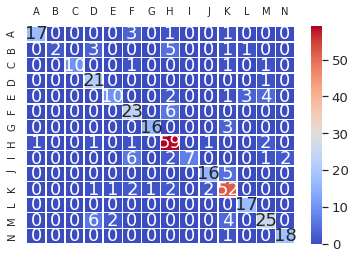

In [ ]:
print( classification_report(y_true, y_pred ) )
cm = confusion_matrix(y_true, y_pred , labels = key_list) 
df_cm = pd.DataFrame(cm, index=key_list, columns=key_list)
# config plot sizes
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: A
Accuracy: 17/17

Class: B
Accuracy: 4/7

Class: C
Accuracy: 7/7

Class: D
Accuracy: 18/18

Class: E
Accuracy: 8/14

Class: F
Accuracy: 16/17

Class: G
Accuracy: 12/12

Class: H
Accuracy: 39/42

Class: I
Accuracy: 5/11

Class: J
Accuracy: 10/13

Class: K
Accuracy: 32/38

Class: L
Accuracy: 9/9

Class: M
Accuracy: 20/23

Class: N
Accuracy: 12/12



# 5 Best model with domain shift

# Conclusion